# ENGIE QTEM Data Challenge – 2025  

This notebook is a comprehensive and reproducible workflow to solve the ENGIE QTEM Data Challenge. The challenge is focused on optimizing a renewable energy asset portfolio based on weather, production, and market pricing data.

### Key Business Questions:
- Which combination of renewable energy assets yields the highest production with the least variability?
- How do revenue considerations (market price data) affect the optimal portfolio selection?
- What are the differences between production-driven and revenue-driven optimization?
- How would the results change if real-world inefficiencies (e.g. curtailments) were removed?

---

### Final Deliverables:
- Reproducible optimization models (production & revenue)
- Portfolio performance metrics (mean output, standard deviation, volatility)
- Comparative analysis & sensitivity insights
- Final report and presentation-ready visualizations

---

### Data Overview:
- **Solar Production Sites:** 71 (Belgium, Germany, Netherlands)
- **Wind Sites:** 99 (onshore + offshore)
- **Weather Variables:** Temperature, wind speed/direction, cloud cover, solar radiation
- **Prices:** Quarter-hourly and hourly market prices (Day-Ahead, Intraday, ISP)
- **Metadata:** Site locations, variable definitions

---

## Available Data:

- **Solar Data Folder:** Contains files for each solar site:
  - Dew Point (`d2m`)
  - Total Cloud Cover (`tcc`)
  - Temperature (`t2m`)
  - Solar Radiation (`ssr`)
  - Wind Angle at 10m (`angle10`)
  - Wind Speed at 10m (`speed10`)
  - Load Factor (`factor`)

- **Wind Data Folder:** Contains files for each wind site:
  - Wind Angle at 100m (`angle100`)
  - Wind Speed at 100m (`speed100`)
  - Load Factor (`factor`)

- **Price and Liquidity Data:**
  - Day Ahead and Intraday prices.

- **Additional Files:**
  - Sites anonymized data (`sites_anonymized.csv`)
  - Data Dictionary (`data_dictionary.xlsx`)

In [1]:
import pandas as pd
import numpy as np
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from glob import glob
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import geodatasets
import contextily as ctx
import os

# 1. Comprehensive Data Assessment

In this section, we:
- Explore metadata to understand the site distribution
- Examine weather, production, and price data structure
- Identify missing values, timestamp irregularities, and data format issues
- Prepare for integration and cleaning

### 📊 Price & Metadata Cleaning Summary

We started with raw datasets including:

- A **pricing CSV** with 59 columns and 132,310 timestamped records, covering multiple market types (Day-Ahead, Intraday, Imbalance) across Belgium (BE), Germany (DE), the Netherlands (NL), and France (FR).
- A **site metadata CSV** covering 170 renewable energy assets with latitude/longitude, type (solar or wind), and technical parameters.

---

#### ✅ Actions Taken on Price Data:

- Removed all `volume` columns, which are not relevant to the ENGIE challenge's optimization scope.
- Dropped all columns related to France (`FR`) since the challenge is limited to **Belgium, Germany, and the Netherlands**.
- Retained Day-Ahead prices (`DA_*`) for each target country.
- Kept **Intraday prices** from `ID1`, `ID3`, and `IDFull`, for both `Hourly` and `Quarter-Hourly (QH)` formats.
- Retained flat **imbalance prices** (`ISP_*`) and **NL-specific imbalance splits** (`ISP_SHORT_NL`, `ISP_LONG_NL`) to support modeling for Parts 2 and 4.
- Parsed the `datetime` column and ensured it was formatted correctly for merging and filtering.

**📦 Resulting price dataset:**
- Shape: **132,310 rows × 26 columns**
- Fully scoped to BE, DE, and NL
- Reproducible and structured for merging with production and weather data

---

#### ✅ Actions Taken on Site Metadata:

- Converted the coordinate-based metadata into a `GeoDataFrame` to enable spatial operations.
- Performed a **spatial join** with the Natural Earth country boundaries shapefile to assign each site to a country using the `'NAME'` field.
- **Manually patched** two offshore wind sites that did not fall within country boundaries by assigning them to **Germany**.
- Removed all sites assigned to **France** from the dataset entirely.
- Finalized and cleaned the resulting `sites_df` by removing spatial join artifacts (`geometry`, `index_right`) and ensuring consistent formatting of site IDs.

**📦 Resulting site metadata:**
- Sites with valid country: **132**
- Sites dropped (France): **~38**
- All remaining sites have a known `type`, `latitude`, `longitude`, and `country`, and are scoped to BE, DE, and NL only.

---

This cleaning process ensures a **fully synchronized foundation** between site-level production data and pricing records, strictly scoped to the challenge objectives. The cleaned `sites_df` is now used consistently throughout the analysis pipeline, ensuring that no French or unmapped sites leak into `part1_df`, `part2_df`, or any later modeling stages.

In [2]:
# Load metadata
sites_df = pd.read_csv("/Users/hossameldinelhendawy/Documents/QDC-Lib/sites_anonymized.csv")
price_df = pd.read_csv("/Users/hossameldinelhendawy/Documents/QDC-Lib/intraday_indices_prices_and_liquidity.csv")

# Datetime column modification
price_df.rename(columns={price_df.columns[0]: "datetime"}, inplace=True)
price_df['datetime'] = pd.to_datetime(price_df['datetime'])

/var/folders/5f/8x4b66f12jxblmgjlz1qymv80000gn/T/ipykernel_48039/3748134077.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  price_df['datetime'] = pd.to_datetime(price_df['datetime'])


In [3]:
# Load and clean Natural Earth shapefile (Admin 0 boundaries)
world = gpd.read_file("/Users/hossameldinelhendawy/Documents/QDC-Lib/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Convert sites_df to GeoDataFrame for join
sites_gdf = gpd.GeoDataFrame(
    sites_df,
    geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
    crs="EPSG:4326"
)

# Perform spatial join to assign countries
sites_with_country = gpd.sjoin(
    sites_gdf,
    world[['NAME', 'geometry']],
    how='left',
    predicate='within'
).reset_index(drop=True)

# Clean up country column
sites_with_country.drop(columns=[col for col in ['country'] if col in sites_with_country.columns], inplace=True)
sites_with_country.rename(columns={'NAME': 'country'}, inplace=True)

# Manually patch offshore wind sites (if any)
sites_with_country.loc[
    (sites_with_country['country'].isna()) &
    (sites_with_country['type'] == 'Wind Offshore'),
    'country'
] = 'Germany'

# Remove French sites
sites_with_country = sites_with_country[sites_with_country['country'] != 'France']

# Drop unused columns
columns_to_drop = [col for col in ['geometry', 'index_right'] if col in sites_with_country.columns]
sites_df = sites_with_country.drop(columns=columns_to_drop).copy()

# Format site ID
sites_df['site'] = sites_df['site'].astype(int)

In [4]:
# Selection of relevant price columns for Parts 1–4
columns_to_keep = ['datetime']

# Add DA prices
for country in ['BE', 'DE', 'NL']:
    col = f'DA_{country}'
    if col in price_df.columns:
        columns_to_keep.append(col)

# Add hourly and QH intraday prices
intraday_types = ['ID1', 'ID3', 'IDFull']
resolutions = ['Hourly', 'QH']

for market in intraday_types:
    for resolution in resolutions:
        for country in ['BE', 'DE', 'NL']:
            col = f'{market}_{resolution}_{country}_price'
            if col in price_df.columns:
                columns_to_keep.append(col)

# Add Imbalance prices
for country in ['BE', 'DE', 'NL']:
    # Flat ISP
    col_flat = f'ISP_{country}'
    if col_flat in price_df.columns:
        columns_to_keep.append(col_flat)
    # NL-specific imbalance split
    col_short = f'ISP_SHORT_{country}'
    col_long = f'ISP_LONG_{country}'
    if col_short in price_df.columns:
        columns_to_keep.append(col_short)
    if col_long in price_df.columns:
        columns_to_keep.append(col_long)

# Apply filter
price_cleaned_df = price_df[columns_to_keep].copy()

## ☀️ Solar Data Preprocessing Summary

We prepared the solar dataset for modeling by executing the following structured pipeline:

### 1. Site Discovery & Variable Definition
- Loaded all `.csv` files from the solar folder
- Extracted 71 unique site IDs
- Defined the target variables:  
  - Weather: `d2m`, `tcc`, `t2m`, `ssr`, `angle10`, `speed10`  
  - Production: `load_factor`

### 2. Per-Site Loading & Merging
- For each site, we loaded its 7 variable files
- Parsed and standardized the `datetime` column
- Merged all variables on `datetime`
- Added a `site_id` column
- Stored the result in `solar_site_data[site_id]`

### 3. Timeline Construction
- Extracted all timestamps across all sites
- Built a unified hourly index:
  - Start: `2018-12-31 23:00:00`
  - End: `2024-10-01 00:00:00`
  - Total timestamps: `50,402`
  - Frequency: **Hourly**

### 4. Site Reindexing
- Reindexed every site’s dataframe to the unified hourly timeline
- Preserved missing data as `NaN`
- Stored aligned sites in `solar_site_data_aligned`

### 5. Final Stacking
- Combined all aligned sites into a single dataframe `solar_all_df`
- Shape: `3,578,542 rows × 9 columns`
- Columns: `datetime`, 6 weather vars, `load_factor`, `site_id`
- Verified 71 unique sites and 50,402 hourly timestamps

This cleaned dataset is now ready for merging with price data and optimization in Phases 2 and 3.


In [5]:
# Setup path
solar_path = "/Users/hossameldinelhendawy/Documents/QDC-Lib/solar"

# All solar files
solar_files = glob(os.path.join(solar_path,"*.csv"))

# Extract site IDs from filenames
solar_site_ids = sorted(
    list(set([f.split('_')[-1].replace('.csv', '') for f in solar_files]))
)

In [6]:
# Variables per site
solar_vars = ['d2m', 'tcc', 't2m', 'ssr', 'angle10', 'speed10', 'load_factor']

def load_solar_site_data(site_id, folder_path):
    dfs = []
    
    for var in solar_vars:
        if var == 'load_factor':
            file_name = f'load_factor_{site_id}.csv'
        else:
            file_name = f'era5_{var}_{site_id}.csv'
        
        file_path = os.path.join(folder_path, file_name)
        
        if not os.path.exists(file_path):
            print(f"[WARNING] Missing file for {var} at site {site_id}")
            continue
        
        df = pd.read_csv(file_path)
        
        # Rename datetime column and parse
        df.rename(columns={df.columns[0]: 'datetime'}, inplace=True)
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        # Rename value column to the variable name
        df.rename(columns={df.columns[1]: var}, inplace=True)
        dfs.append(df)
    
    if not dfs:
        print(f"[ERROR] No data found for site {site_id}")
        return None
    
    # Merge on datetime
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='datetime', how='outer')
    
    merged_df['site_id'] = site_id
    return merged_df

In [7]:
# Extract solar sites files into one dict
solar_site_data = {}

for site_id in solar_site_ids:
    try:
        merged_site_df = load_solar_site_data(site_id, solar_path)
        if merged_site_df is not None:
            solar_site_data[site_id] = merged_site_df
    except Exception as e:
        print(f"[ERROR] Failed to load site {site_id}: {e}")

In [8]:
# How many wind sites loaded successfully?
print("✅ Solar sites loaded:", len(solar_site_data))

# Print column names for a sample site
sample_id = list(solar_site_data.keys())[0]
print("📋 Sample columns for site", sample_id)
print(solar_site_data[sample_id].columns.tolist())

✅ Solar sites loaded: 71
📋 Sample columns for site 026396
['datetime', 'd2m', 'tcc', 't2m', 'ssr', 'angle10', 'speed10', 'load_factor', 'site_id']


In [9]:
# Collect all datetime values from all sites
datetime_series_list = [df['datetime'] for df in solar_site_data.values()]
all_timestamps = pd.concat(datetime_series_list, ignore_index=True)

# Drop duplicates and sort
all_timestamps = pd.to_datetime(all_timestamps.unique())
all_timestamps = pd.Series(sorted(all_timestamps))

# Inspect time coverage and frequency
print("📆 Datetime coverage:")
print("Start:", all_timestamps.min())
print("End  :", all_timestamps.max())
print("\n🕒 Time interval frequencies:")
print(all_timestamps.diff().value_counts().head())
print("\n🔢 Total unique timestamps:", len(all_timestamps))

📆 Datetime coverage:
Start: 2018-12-31 23:00:00+00:00
End  : 2024-10-01 00:00:00+00:00

🕒 Time interval frequencies:
0 days 01:00:00    50401
Name: count, dtype: int64

🔢 Total unique timestamps: 50402


In [10]:
# Align each site to the master datetime index

# Create the master datetime index (hourly)
datetime_index = pd.DatetimeIndex(all_timestamps)

# New dictionary to hold reindexed data
solar_site_data_aligned = {}

# Use tqdm to track loading progress
for site_id, df in tqdm(solar_site_data.items(), desc="Reindexing sites"):
    df = df.set_index('datetime')
    
    # Reindex to fill in all missing timestamps with NaNs
    df = df.reindex(datetime_index)
    
    # Keep the site_id in a column
    df['site_id'] = site_id
    
    # Store in the new aligned dictionary
    df.index.name = 'datetime'
    solar_site_data_aligned[site_id] = df.reset_index()


Reindexing sites: 100%|██████████| 71/71 [00:00<00:00, 113.34it/s]


In [11]:
# Pick a sample site to check
sample_id = list(solar_site_data_aligned.keys())[0]
sample_df = solar_site_data_aligned[sample_id]

print(f"✅ Sample site: {sample_id}")
print("Rows:", sample_df.shape[0])
print("Expected rows:", len(datetime_index))
display(sample_df.head())

✅ Sample site: 026396
Rows: 50402
Expected rows: 50402


,datetime,d2m,tcc,t2m,ssr,angle10,speed10,load_factor,site_id
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,026396
1,2019-01-01 00:00:00+00:00,279.732910,1.000000,281.158844,0.0,0.179575,3.395970,0.000084,026396
2,2019-01-01 01:00:00+00:00,279.169403,0.941495,280.837677,0.0,0.228696,3.402579,0.000084,026396
3,2019-01-01 02:00:00+00:00,278.669128,0.998993,280.659973,0.0,0.226669,3.528860,0.000085,026396
4,2019-01-01 03:00:00+00:00,278.274231,0.990234,280.580109,0.0,0.284809,3.603586,0.000084,026396


In [12]:
# Combine all aligned sites into one big dataframe
solar_all_df = pd.concat(solar_site_data_aligned.values(), ignore_index=True)

print("✅ Combined solar dataset shape:", solar_all_df.shape)
print("🔍 Columns:", solar_all_df.columns.tolist())

# Check number of unique sites and timestamps
print("📌 Unique site IDs:", solar_all_df['site_id'].nunique())
print("📆 Unique timestamps:", solar_all_df['datetime'].nunique())

# Optional: quick data preview
display(solar_all_df.head())


✅ Combined solar dataset shape: (3578542, 9)
🔍 Columns: ['datetime', 'd2m', 'tcc', 't2m', 'ssr', 'angle10', 'speed10', 'load_factor', 'site_id']
📌 Unique site IDs: 71
📆 Unique timestamps: 50402


,datetime,d2m,tcc,t2m,ssr,angle10,speed10,load_factor,site_id
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,026396
1,2019-01-01 00:00:00+00:00,279.732910,1.000000,281.158844,0.0,0.179575,3.395970,0.000084,026396
2,2019-01-01 01:00:00+00:00,279.169403,0.941495,280.837677,0.0,0.228696,3.402579,0.000084,026396
3,2019-01-01 02:00:00+00:00,278.669128,0.998993,280.659973,0.0,0.226669,3.528860,0.000085,026396
4,2019-01-01 03:00:00+00:00,278.274231,0.990234,280.580109,0.0,0.284809,3.603586,0.000084,026396


## 🌬️ Wind Data Preprocessing Summary

We applied a structured pipeline to prepare the wind site data for portfolio optimization. This followed the same logic as the solar data, with minor adjustments based on available variables.

---

### 1. Site Discovery & Variable Definition
- Loaded all `.csv` files from the `wind/` folder
- Extracted **99 unique wind site IDs**
- Defined 3 target variables:
  - `angle100` – wind direction at 100m
  - `speed100` – wind speed at 100m
  - `load_factor` – actual site production as a fraction of capacity

---

### 2. Per-Site Loading & Merging
- Loaded all available variable files for each wind site
- Parsed and standardized the `datetime` column
- Renamed value columns for clarity
- Merged the variables on `datetime`
- Added a `site_id` column
- Stored merged site data in `wind_site_data[site_id]`

Missing files (e.g., `angle100`) were gracefully skipped with warnings. Sites with no valid files were excluded.

---

### 3. Reindexing to Master Timeline
- Reused the unified hourly `datetime_index` created from the solar phase
- Reindexed all wind sites to this common timeline:
  - Start: `2018-12-31 23:00:00`
  - End: `2024-10-01 00:00:00`
  - Total timestamps: `50,402`
- Preserved `NaN`s for any missing intervals
- Stored aligned dataframes in `wind_site_data_aligned`

---

### 4. Final Stacking
- Concatenated all aligned wind sites into a single long-format dataframe `wind_all_df`
- Shape: `4,989,798 rows × 5 columns`
- Columns: `datetime`, `angle100`, `speed100`, `load_factor`, `site_id`
- Verified:
  - ✅ 99 unique `site_id`s
  - ✅ 50,402 unique hourly `datetime`s

---

### ✅ Outcome
The `wind_all_df` dataframe is now fully cleaned and aligned, ready to be merged with solar data and price data for Phase 2:
- Production analysis
- Portfolio optimization
- Revenue modeling

In [13]:
# Setup path
wind_path = "/Users/hossameldinelhendawy/Documents/QDC-Lib/wind"

# All wind files
wind_files = glob(os.path.join(wind_path, "*.csv"))

# Extract wind site IDs
wind_site_ids = sorted(
    list(set([f.split('_')[-1].replace('.csv', '') for f in wind_files]))
)

# Variables per wind site
wind_vars = ['angle100', 'speed100', 'load_factor']

def load_wind_site_data(site_id, folder_path):
    dfs = []
    
    for var in wind_vars:
        if var == 'load_factor':
            file_name = f'load_factor_{site_id}.csv'
        else:
            file_name = f'era5_{var}_{site_id}.csv'
        
        file_path = os.path.join(folder_path, file_name)
        
        if not os.path.exists(file_path):
            print(f"[WARNING] Missing file for {var} at site {site_id}")
            continue
        
        df = pd.read_csv(file_path)
        
        # Rename datetime column and parse
        df.rename(columns={df.columns[0]: 'datetime'}, inplace=True)
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        # Rename value column to the variable name
        df.rename(columns={df.columns[1]: var}, inplace=True)
        dfs.append(df)
    
    if not dfs:
        print(f"[ERROR] No data found for site {site_id}")
        return None
    
    # Merge on datetime
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='datetime', how='outer')
    
    merged_df['site_id'] = site_id
    return merged_df

# Load all wind sites into dictionary
wind_site_data = {}

for site_id in wind_site_ids:
    try:
        merged_site_df = load_wind_site_data(site_id, wind_path)
        if merged_site_df is not None:
            wind_site_data[site_id] = merged_site_df
    except Exception as e:
        print(f"[ERROR] Failed to load site {site_id}: {e}")


In [14]:
# How many wind sites loaded successfully?
print("✅ Wind sites loaded:", len(wind_site_data))

# Print column names for a sample site
sample_id = list(wind_site_data.keys())[0]
print("📋 Sample columns for site", sample_id)
print(wind_site_data[sample_id].columns.tolist())

✅ Wind sites loaded: 99
📋 Sample columns for site 008807
['datetime', 'angle100', 'speed100', 'load_factor', 'site_id']


In [15]:
# Master index from solar
datetime_index = pd.DatetimeIndex(all_timestamps)

# New dictionary for aligned wind data
wind_site_data_aligned = {}

for site_id, df in tqdm(wind_site_data.items(), desc="Reindexing wind sites"):
    df = df.set_index('datetime')
    df = df.reindex(datetime_index)
    df['site_id'] = site_id
    df.index.name = 'datetime'
    wind_site_data_aligned[site_id] = df.reset_index()

Reindexing wind sites: 100%|██████████| 99/99 [00:00<00:00, 154.35it/s]


In [16]:
# Pick a sample site to check
sample_id = list(wind_site_data_aligned.keys())[0]
sample_df = wind_site_data_aligned[sample_id]

print(f"✅ Sample wind site: {sample_id}")
print("Rows:", sample_df.shape[0])
print("Expected rows (from master index):", len(datetime_index))
print("Missing values per column:")
print(sample_df.isnull().sum())

display(sample_df.head())

✅ Sample wind site: 008807
Rows: 50402
Expected rows (from master index): 50402
Missing values per column:
datetime           0
angle100         337
speed100         337
load_factor    32858
site_id            0
dtype: int64


,datetime,angle100,speed100,load_factor,site_id
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,008807
1,2019-01-01 00:00:00+00:00,0.219218,7.563506,NaN,008807
2,2019-01-01 01:00:00+00:00,0.295403,7.909504,NaN,008807
3,2019-01-01 02:00:00+00:00,0.276935,8.721675,NaN,008807
4,2019-01-01 03:00:00+00:00,0.265117,9.621751,NaN,008807


In [17]:
# Combine all aligned wind sites into one big dataframe
wind_all_df = pd.concat(wind_site_data_aligned.values(), ignore_index=True)

print("✅ Combined wind dataset shape:", wind_all_df.shape)
print("🔍 Columns:", wind_all_df.columns.tolist())

# Check number of unique sites and timestamps
print("📌 Unique site IDs:", wind_all_df['site_id'].nunique())
print("📆 Unique timestamps:", wind_all_df['datetime'].nunique())

# Optional: preview
display(wind_all_df.head())

✅ Combined wind dataset shape: (4989798, 5)
🔍 Columns: ['datetime', 'angle100', 'speed100', 'load_factor', 'site_id']
📌 Unique site IDs: 99
📆 Unique timestamps: 50402


,datetime,angle100,speed100,load_factor,site_id
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,008807
1,2019-01-01 00:00:00+00:00,0.219218,7.563506,NaN,008807
2,2019-01-01 01:00:00+00:00,0.295403,7.909504,NaN,008807
3,2019-01-01 02:00:00+00:00,0.276935,8.721675,NaN,008807
4,2019-01-01 03:00:00+00:00,0.265117,9.621751,NaN,008807


## 📦 2. Dataset Integration & Phase Dataset Preparation Summary

In this section, we consolidated all production and price-related data into a unified, filtered structure, and prepared the datasets required for Phase 1 and Phase 2 of the challenge.

---

### ✅ Step 1: Filter and Merge Solar & Wind Datasets
- Added a `source` tag (`solar` or `wind`) to each production dataset.
- Ensured consistency by converting all `site_id` columns to integers.
- Filtered out any site not present in the cleaned metadata (`sites_df`) — ensuring all production records belong only to valid, non-French, properly tagged assets.
- Concatenated the filtered solar and wind datasets into a single `production_df`.

---

### 🔗 Step 2: Join with Cleaned Site Metadata
- Merged `production_df` with the cleaned `sites_df` using `site_id`.
- This added important metadata columns such as:
  - `type` (Solar, Wind Onshore, Wind Offshore)
  - `latitude`, `longitude`
  - `country` (validated using spatial join)
  - `capacity` (optional — relevant in Phase 4)

---

### 🕒 Step 3: Datetime Normalization
- Converted all `datetime` columns in both `price_cleaned_df` and `all_sites_df` to **timezone-naive UTC format**.
- This ensured consistent alignment when merging production with market prices.

---

### 🔄 Step 4: Merge with Price Dataset
- Merged the enriched production data (`all_sites_df`) with `price_cleaned_df` using `datetime` as the key.
- Resulting `exploratory_df` combines:
  - Site metadata
  - Production metrics (load factor)
  - Market price signals

This dataset now serves as the **foundation** for all later analytical and optimization tasks.

---

## 📊 Phase 1 Dataset: Production Optimization

- Extracted a minimal column set focused on production variables:
  - `datetime`, `site_id`, `load_factor`, `source`, `type`, `latitude`, `longitude`, 'country'
- Removed rows with missing `load_factor` values.
- Resulting `part1_df` is used to analyze **site-level productivity and stability**, assuming all sites operate under equal nominal capacity.

---

## 💰 Phase 2 Dataset: Revenue Optimization

- Extended `part1_df` with all relevant price-related features, including:
  - `DA_*`, `ID1_*`, `ID3_*`, and `ISP_*` columns
- Dropped rows with missing `load_factor`.
- Resulting `part2_df` enables site-level **revenue estimation** and optimization modeling based on price signals.

---

### ✅ Final Output Summary

- `exploratory_df`: Full merged dataset (production + price + metadata)
- `part1_df`: Phase 1 dataset (production-focused)
- `part2_df`: Phase 2 dataset (revenue-focused)

All datasets are consistently filtered, France-free, timezone-aligned, and ready for modeling and visualization in the next phases of the challenge.

In [18]:
# Add source tag
solar_all_df['source'] = 'solar'
wind_all_df['source'] = 'wind'

# Ensure site_id columns are integers for join
solar_all_df['site_id'] = solar_all_df['site_id'].astype(int)
wind_all_df['site_id'] = wind_all_df['site_id'].astype(int)
sites_df['site'] = sites_df['site'].astype(int)

# Keep only production for sites that are in the filtered metadata
valid_site_ids = sites_df['site'].unique()
solar_all_df = solar_all_df[solar_all_df['site_id'].isin(valid_site_ids)]
wind_all_df = wind_all_df[wind_all_df['site_id'].isin(valid_site_ids)]

# Merge solar and wind into one full production dataframe
production_df = pd.concat([solar_all_df, wind_all_df], ignore_index=True)

# Join with metadata
all_sites_df = production_df.merge(
    sites_df.rename(columns={'site': 'site_id'}),
    on='site_id',
    how='left'
)

# Check results
print("✅ Final unified production dataset shape:", all_sites_df.shape)
print("🔍 Columns:", all_sites_df.columns.tolist())
print("📌 Unique sites:", all_sites_df['site_id'].nunique())
print("🕒 Unique timestamps:", all_sites_df['datetime'].nunique())
print("🔢 Source breakdown:")
print(all_sites_df['source'].value_counts())

# Preview
display(all_sites_df.head())

✅ Final unified production dataset shape: (6955476, 17)
🔍 Columns: ['datetime', 'd2m', 'tcc', 't2m', 'ssr', 'angle10', 'speed10', 'load_factor', 'site_id', 'source', 'angle100', 'speed100', 'latitude', 'longitude', 'type', 'capacity', 'country']
📌 Unique sites: 130
🕒 Unique timestamps: 50402
🔢 Source breakdown:
source
wind     4788190
solar    2167286
Name: count, dtype: int64


,datetime,d2m,tcc,t2m,ssr,angle10,speed10,load_factor,site_id,source,angle100,speed100,latitude,longitude,type,capacity,country
0,2018-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium
1,2019-01-01 00:00:00+00:00,279.732910,1.000000,281.158844,0.0,0.179575,3.395970,0.000084,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium
2,2019-01-01 01:00:00+00:00,279.169403,0.941495,280.837677,0.0,0.228696,3.402579,0.000084,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium
3,2019-01-01 02:00:00+00:00,278.669128,0.998993,280.659973,0.0,0.226669,3.528860,0.000085,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium
4,2019-01-01 03:00:00+00:00,278.274231,0.990234,280.580109,0.0,0.284809,3.603586,0.000084,26396,solar,NaN,NaN,51.091425,3.780883,Solar,448.0,Belgium


In [19]:
# Remove timezone from price_cleaned_df datetime
price_cleaned_df['datetime'] = pd.to_datetime(price_cleaned_df['datetime'], utc=True)
price_cleaned_df['datetime'] = price_cleaned_df['datetime'].dt.tz_localize(None)

# Remove timezone from all_sites_df datetime
all_sites_df['datetime'] = pd.to_datetime(all_sites_df['datetime'], utc=True)
all_sites_df['datetime'] = all_sites_df['datetime'].dt.tz_localize(None)

# ✅ Optional check
assert all_sites_df['datetime'].dt.tz is None
assert price_cleaned_df['datetime'].dt.tz is None

# Merge
exploratory_df = all_sites_df.merge(price_cleaned_df, on='datetime', how='left')

# Sanity check
print("✅ Exploratory dataset shape:", exploratory_df.shape)
print("📌 Unique sites:", exploratory_df['site_id'].nunique())
print("🕒 Unique timestamps:", exploratory_df['datetime'].nunique())
print("🔢 Sources:", exploratory_df['source'].value_counts())
display(exploratory_df.head())


✅ Exploratory dataset shape: (6955476, 42)
📌 Unique sites: 130
🕒 Unique timestamps: 50402
🔢 Sources: source
wind     4788190
solar    2167286
Name: count, dtype: int64


,datetime,d2m,tcc,t2m,ssr,angle10,speed10,load_factor,site_id,source,...,IDFull_Hourly_BE_price,IDFull_Hourly_DE_price,IDFull_Hourly_NL_price,IDFull_QH_BE_price,IDFull_QH_DE_price,IDFull_QH_NL_price,ISP_BE,ISP_DE,ISP_SHORT_NL,ISP_LONG_NL
0,2018-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 00:00:00,279.732910,1.000000,281.158844,0.0,0.179575,3.395970,0.000084,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 01:00:00,279.169403,0.941495,280.837677,0.0,0.228696,3.402579,0.000084,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 02:00:00,278.669128,0.998993,280.659973,0.0,0.226669,3.528860,0.000085,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 03:00:00,278.274231,0.990234,280.580109,0.0,0.284809,3.603586,0.000084,26396,solar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Only production-related variables
part1_df = exploratory_df[[
    'datetime',
    'site_id',
    'load_factor',
    'source',
    'type',
    'latitude',
    'longitude',
    'country'
]].copy()

# Drop rows with missing load factor
part1_df = part1_df[~part1_df['load_factor'].isna()]

# Check result
print("✅ Phase 1 dataset shape:", part1_df.shape)
print("📌 Unique sites:", part1_df['site_id'].nunique())
print("🕒 Unique timestamps:", part1_df['datetime'].nunique())
print("🔢 Source breakdown:")
print(part1_df['source'].value_counts())
display(part1_df.head())

✅ Phase 1 dataset shape: (3496083, 8)
📌 Unique sites: 130
🕒 Unique timestamps: 50401
🔢 Source breakdown:
source
wind     2447469
solar    1048614
Name: count, dtype: int64


,datetime,site_id,load_factor,source,type,latitude,longitude,country
1,2019-01-01 00:00:00,26396,0.000084,solar,Solar,51.091425,3.780883,Belgium
2,2019-01-01 01:00:00,26396,0.000084,solar,Solar,51.091425,3.780883,Belgium
3,2019-01-01 02:00:00,26396,0.000085,solar,Solar,51.091425,3.780883,Belgium
4,2019-01-01 03:00:00,26396,0.000084,solar,Solar,51.091425,3.780883,Belgium
5,2019-01-01 04:00:00,26396,0.000085,solar,Solar,51.091425,3.780883,Belgium


In [21]:
# Define all columns relevant for revenue modeling
price_columns = [col for col in exploratory_df.columns if any(tag in col for tag in ['DA_', 'ID1_', 'ID3_', 'ISP_'])]

# Build Phase 2 dataset
part2_df = exploratory_df[[
    'datetime',
    'site_id',
    'load_factor',
    'source',
    'type',
    'latitude',
    'longitude',
    'country'
] + price_columns].copy()

# Drop rows with missing load_factor
part2_df = part2_df[~part2_df['load_factor'].isna()]

# Check result
print("✅ Phase 2 dataset shape:", part2_df.shape)
print("📌 Unique sites:", part2_df['site_id'].nunique())
print("🕒 Unique timestamps:", part2_df['datetime'].nunique())
print("🔢 Source breakdown:")
print(part2_df['source'].value_counts())
display(part2_df.head())

✅ Phase 2 dataset shape: (3496083, 27)
📌 Unique sites: 130
🕒 Unique timestamps: 50401
🔢 Source breakdown:
source
wind     2447469
solar    1048614
Name: count, dtype: int64


,datetime,site_id,load_factor,source,type,latitude,longitude,country,DA_BE,DA_DE,...,ID3_Hourly_BE_price,ID3_Hourly_DE_price,ID3_Hourly_NL_price,ID3_QH_BE_price,ID3_QH_DE_price,ID3_QH_NL_price,ISP_BE,ISP_DE,ISP_SHORT_NL,ISP_LONG_NL
1,2019-01-01 00:00:00,26396,0.000084,solar,Solar,51.091425,3.780883,Belgium,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 01:00:00,26396,0.000084,solar,Solar,51.091425,3.780883,Belgium,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 02:00:00,26396,0.000085,solar,Solar,51.091425,3.780883,Belgium,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 03:00:00,26396,0.000084,solar,Solar,51.091425,3.780883,Belgium,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-01-01 04:00:00,26396,0.000085,solar,Solar,51.091425,3.780883,Belgium,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 📊 3. Exploratory Data Analysis (EDA)

In this chapter, we explore and analyze the cleaned and merged dataset (`exploratory_df`) to understand key structural and behavioral patterns across different renewable energy assets in Belgium, Germany, and the Netherlands. Our goal is to derive business-relevant insights that will guide the modeling and optimization phases.

---

### 🧮 Site Overview and Metadata Breakdown

- **Total unique sites:** 130  
- **Source types:**  
  - Solar: 35  
  - Wind: 95  

- **Technology types:**  
  - Solar: 35  
  - Wind Onshore: 93  
  - Wind Offshore: 2  

- **Country-level distribution:**  
  - Germany: 96  
  - Netherlands: 23  
  - Belgium: 11  

#### 🔢 Matrix: Country × Type

| Country     | Solar | Wind Offshore | Wind Onshore |
|-------------|--------|----------------|----------------|
| Belgium     | 6      | 0              | 5              |
| Germany     | 10     | 2              | 84             |
| Netherlands | 19     | 0              | 4              |

#### 🌍 Geographic Distribution

A scatter plot of all site coordinates (longitude vs. latitude) visually highlights the regional clustering of solar and wind sites:
- **Solar assets** are more common in the Netherlands and western Germany.
- **Wind Onshore** assets dominate central and northern Germany.
- **Wind Offshore** assets are only present in Germany.

---

### 📅 Temporal Coverage

- **Start date:** 2018-12-31 23:00:00  
- **End date:** 2024-10-01 00:00:00  
- **Total unique hourly timestamps:** 50,402  

This comprehensive 5+ year window enables strong temporal learning and seasonal pattern detection.

---

### ⚡ Load Factor Distribution

- A histogram of `load_factor` reveals a **right-skewed distribution**, with the majority of observations concentrated at low to moderate values (0.0–0.3).  
- **Boxplot comparisons** by technology type show:  
  - **Wind Offshore** has the highest median load factor and tightest interquartile range.  
  - **Wind Onshore** shows more variability and slightly lower performance.  
  - **Solar** exhibits a lower median load factor but more frequent peaks.

---

### 🕒 Load Factor by Hour of Day

A multi-line hourly profile grouped by `type × country` shows:
- **Solar sites** peak strongly between **10:00–14:00**, with near-zero output at night.  
- **Wind Onshore/Offshore** show flatter profiles, though onshore tends to dip slightly during daytime.  
- **Wind Offshore** in Germany maintains the highest and most stable hourly performance.

---

### 📅 Monthly Load Factor Trends

Line plots of average monthly load factor by type from 2019 to 2024 show:
- **Solar** follows a clear seasonal curve with peaks in summer months.  
- **Wind Onshore and Offshore** exhibit higher volatility, with winter months often showing stronger performance.  
- Offshore wind sites are the most consistent performers over time.

---

### 📈 Site Performance & Variability

Using the coefficient of variation (CV = std / mean), we identify:

#### 🔝 Most Stable Sites (lowest CV):

- Top performers are **Wind Offshore and Wind Onshore sites** in Germany and Belgium.  
- Stability indicates consistent generation, beneficial for revenue predictability.

#### 🔻 Most Unstable Sites (highest CV):

- Dominated by **Solar and low-performing Wind Onshore** assets.  
- High CV values suggest intermittent and unreliable generation, likely affected by weather/cloud cover.

---

### 💹 Correlation with Market Prices

- A correlation heatmap between `load_factor` and all **Day-Ahead (DA)**, **Intraday (ID1, ID3, IDFull)**, and **Imbalance (ISP)** price layers reveals:
  - `load_factor` shows **negative correlation (~ -0.1 to -0.2)** with most price signals, implying price dips during high production (oversupply).
  - Strong **inter-correlation between price layers (>0.9)** across countries and products indicates consistent market behavior.

---

### 🏆 Top vs. Bottom Performing Sites

#### Top 10 Sites by Average Load Factor:
- Mostly **Wind Offshore and Onshore** assets, particularly from Germany and Belgium.  
- Load factors above 0.27–0.42 reflect strong capacity utilization.

#### Bottom 10 Sites:
- Predominantly **Solar** and poorly located **Wind Onshore** assets, with average load factors as low as 0.02.  
- These underperformers may need to be deprioritized in optimization or reconsidered in investment planning.

---

### ✅ Summary of Business Insights

- **Wind (especially Offshore)** is the most consistent and productive asset class in the dataset.  
- **Solar energy** shows strong daytime patterns and seasonal curves, but performance varies more site-to-site.  
- **Germany dominates** in both asset volume and diversity, offering ample optimization potential.  
- **Temporal and price correlations** suggest that overproduction drives prices down, reinforcing the need for timing-optimized bidding strategies.  
- The **performance distribution** across sites justifies selective investment, deactivation, or reallocation based on capacity factors and volatility.

This rich exploratory analysis lays the foundation for performance clustering, revenue optimization, and future forecasting efforts in the next modeling phases.

In [22]:
# Total number of unique sites
total_sites = exploratory_df['site_id'].nunique()
print(f"📌 Total unique sites: {total_sites}")

# Breakdown by source (solar/wind)
print("\n🔢 Source breakdown:")
display(exploratory_df.groupby('source')['site_id'].nunique())

# Breakdown by type (Solar, Wind Onshore, Wind Offshore)
print("\n🔢 Type breakdown:")
display(exploratory_df.groupby('type')['site_id'].nunique())

# Breakdown by country
print("\n🌍 Country breakdown:")
display(exploratory_df.groupby('country')['site_id'].nunique())

# Matrix: Country × Type
print("\n📊 Site count by Country × Type:")
country_type_matrix = exploratory_df.groupby(['country', 'type'])['site_id'].nunique().unstack(fill_value=0)
display(country_type_matrix)

📌 Total unique sites: 130

🔢 Source breakdown:


source
solar    35
wind     95
Name: site_id, dtype: int64


🔢 Type breakdown:


type
Solar            35
Wind Offshore     2
Wind Onshore     93
Name: site_id, dtype: int64


🌍 Country breakdown:


country
Belgium        11
Germany        96
Netherlands    23
Name: site_id, dtype: int64


📊 Site count by Country × Type:


type,Solar,Wind Offshore,Wind Onshore
country,,,
Belgium,6,0,5
Germany,10,2,84
Netherlands,19,0,4


/opt/anaconda3/envs/QDC/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/QDC/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


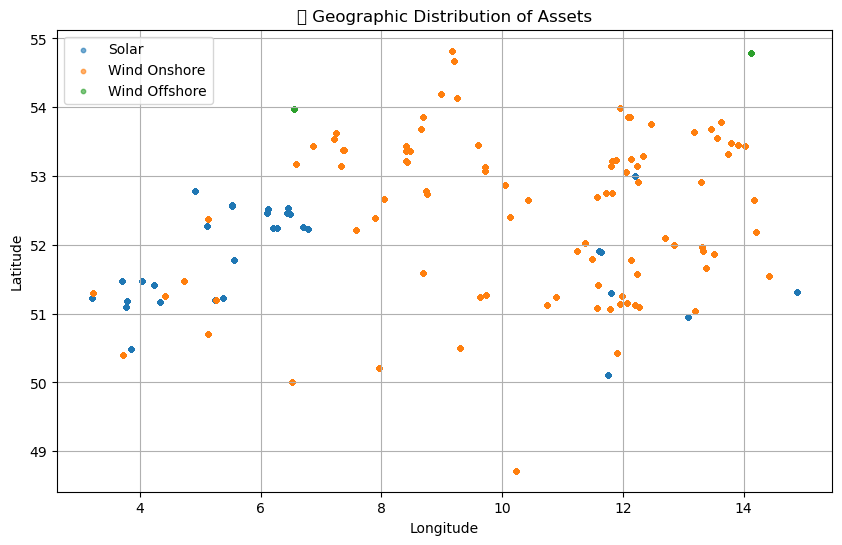

In [23]:
# Plot all sites by latitude and longitude
plt.figure(figsize=(10, 6))
for site_type in exploratory_df['type'].unique():
    subset = exploratory_df[exploratory_df['type'] == site_type]
    plt.scatter(subset['longitude'], subset['latitude'], label=site_type, alpha=0.6, s=10)

plt.title("🌍 Geographic Distribution of Assets")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Define the map center roughly at central Europe
map_center = [50.5, 8.0]  # Between Germany, BE, and NL
m = folium.Map(location=map_center, zoom_start=6, tiles='OpenStreetMap')

# Color mapping by type
color_map = {
    'Solar': 'orange',
    'Wind Onshore': 'blue',
    'Wind Offshore': 'green'
}

# Add asset locations with MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

for _, row in sites_df.iterrows():
    tooltip = f"Site ID: {row['site']}<br>Type: {row['type']}<br>Capacity: {row['capacity']}"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color_map.get(row['type'], 'gray'),
        fill=True,
        fill_opacity=0.7,
        tooltip=tooltip
    ).add_to(marker_cluster)

# Display map
m

In [25]:
print("📆 Datetime coverage:")
print("Start:", exploratory_df['datetime'].min())
print("End  :", exploratory_df['datetime'].max())

# Count timestamps
print("\n🕒 Number of unique hourly timestamps:", exploratory_df['datetime'].nunique())

📆 Datetime coverage:
Start: 2018-12-31 23:00:00
End  : 2024-10-01 00:00:00

🕒 Number of unique hourly timestamps: 50402


<Axes: xlabel='type', ylabel='country'>

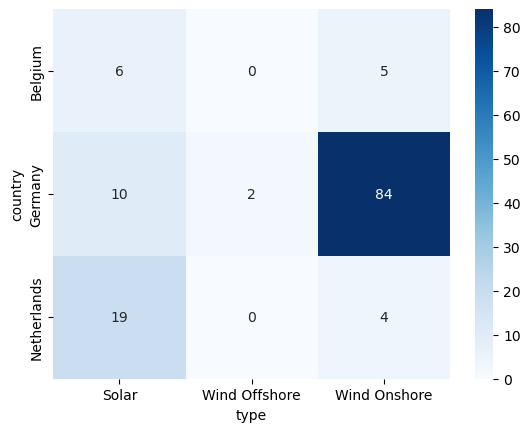

In [26]:
# Heatmap: Country × Type
country_type_matrix = exploratory_df.groupby(['country', 'type'])['site_id'].nunique().unstack(fill_value=0)
sns.heatmap(country_type_matrix, annot=True, cmap="Blues")


<Axes: xlabel='load_factor', ylabel='Count'>

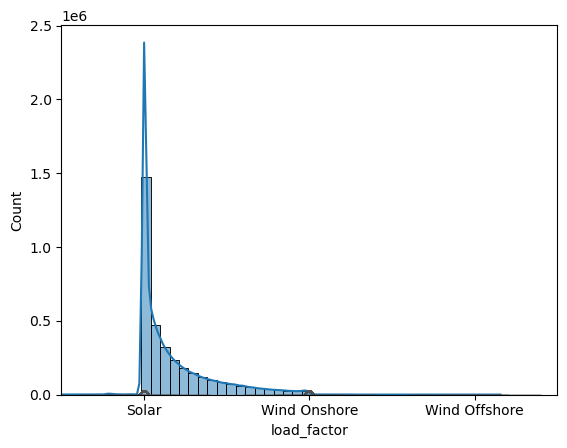

In [27]:
# Histogram: Load factor distribution
sns.histplot(exploratory_df['load_factor'], bins=50, kde=True)

# Boxplot by type
sns.boxplot(data=exploratory_df, x='type', y='load_factor')


/var/folders/5f/8x4b66f12jxblmgjlz1qymv80000gn/T/ipykernel_48039/3369581006.py:22: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/QDC/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


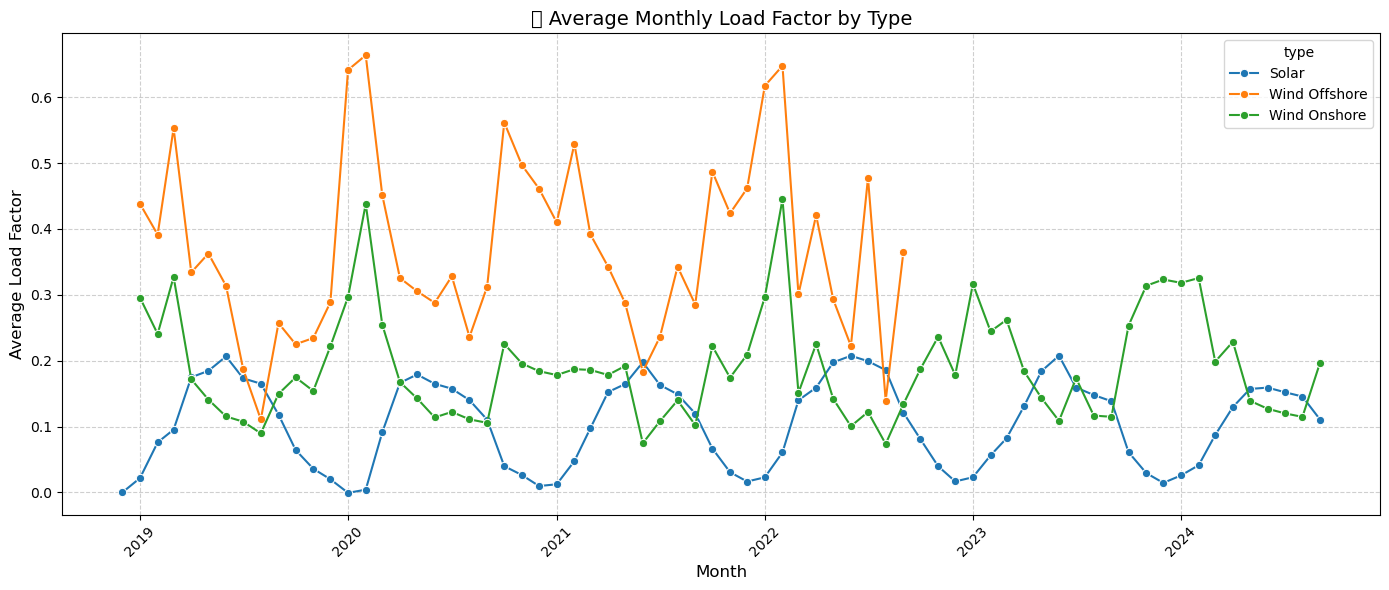

In [28]:
# Extract year-month as a datetime
exploratory_df['month'] = exploratory_df['datetime'].dt.to_period('M').dt.to_timestamp()

# Average load factor per month and type
monthly_avg = exploratory_df.groupby(['month', 'type'])['load_factor'].mean().reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=monthly_avg,
    x='month',
    y='load_factor',
    hue='type',
    marker='o',
    palette='tab10'
)
plt.title("📅 Average Monthly Load Factor by Type", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Load Factor", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
# Calculate standard deviation and mean of load_factor per site
site_variability = exploratory_df.groupby('site_id')['load_factor'].agg(['mean', 'std']).reset_index()

# Calculate coefficient of variation (CV) = std / mean
site_variability['cv'] = site_variability['std'] / site_variability['mean']

# Join with metadata
site_variability = site_variability.merge(
    exploratory_df[['site_id', 'type', 'country']].drop_duplicates(),
    on='site_id',
    how='left'
)

# Display top/bottom 5 by stability
print("🔝 Most Stable Sites (lowest CV):")
display(site_variability.sort_values(by='cv').head(5))

print("🔻 Most Unstable Sites (highest CV):")
display(site_variability.sort_values(by='cv', ascending=False).head(5))


🔝 Most Stable Sites (lowest CV):


,site_id,mean,std,cv,type,country
9,54953,0.427162,0.351788,0.823547,Wind Offshore,Germany
8,53223,0.310760,0.290462,0.934683,Wind Onshore,Germany
5,38793,0.277949,0.264042,0.949966,Wind Onshore,Germany
85,620871,0.335997,0.329150,0.979620,Wind Onshore,Belgium
61,387062,0.220048,0.217261,0.987339,Wind Onshore,Germany


🔻 Most Unstable Sites (highest CV):


,site_id,mean,std,cv,type,country
77,583484,0.026203,0.196625,7.504046,Solar,Netherlands
18,108261,0.050554,0.101645,2.010606,Wind Onshore,Germany
104,750916,0.082082,0.154543,1.882778,Wind Onshore,Germany
115,893953,0.113374,0.198634,1.752035,Wind Onshore,Germany
81,613201,0.099769,0.173305,1.737055,Solar,Netherlands


/var/folders/5f/8x4b66f12jxblmgjlz1qymv80000gn/T/ipykernel_48039/3366551845.py:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/QDC/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


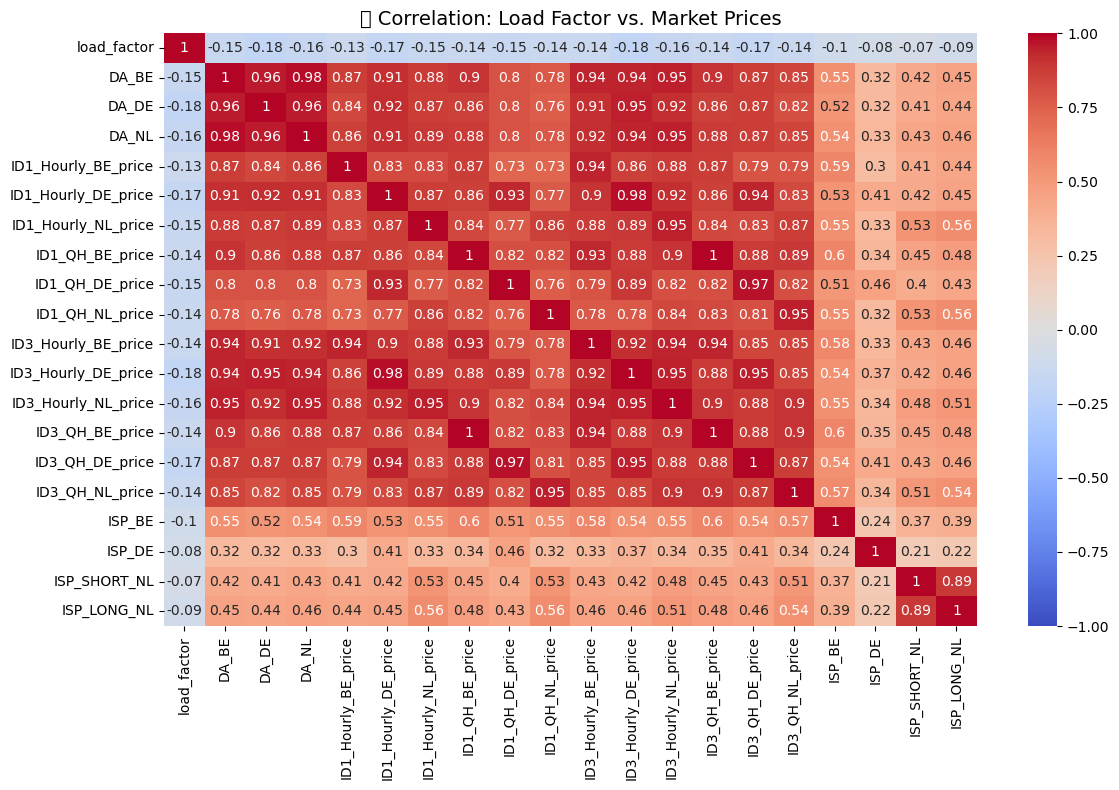

In [30]:
# Select relevant columns
price_cols = [col for col in exploratory_df.columns if any(tag in col for tag in ['DA_', 'ID1_', 'ID3_', 'ISP_'])]
corr_df = exploratory_df[['load_factor'] + price_cols].copy()

# Drop rows with NaNs
corr_df = corr_df.dropna()

# Correlation matrix
corr_matrix = corr_df.corr().round(2)

# Visualize
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("📊 Correlation: Load Factor vs. Market Prices", fontsize=14)
plt.tight_layout()
plt.show()

In [31]:
# Calculate average load factor per site
top_sites = exploratory_df.groupby('site_id')['load_factor'].mean().reset_index()
top_sites.rename(columns={'load_factor': 'avg_load_factor'}, inplace=True)

# Merge metadata for context
top_sites = top_sites.merge(
    exploratory_df[['site_id', 'type', 'country']].drop_duplicates(),
    on='site_id',
    how='left'
)

# Sort by performance
top_sites = top_sites.sort_values(by='avg_load_factor', ascending=False)

# Display top 10 and bottom 10
print("🏆 Top 10 Performing Sites:")
display(top_sites.head(10))

print("🚨 Bottom 10 Performing Sites:")
display(top_sites.tail(10))

🏆 Top 10 Performing Sites:


,site_id,avg_load_factor,type,country
9,54953,0.427162,Wind Offshore,Germany
85,620871,0.335997,Wind Onshore,Belgium
8,53223,0.310760,Wind Onshore,Germany
94,683875,0.303614,Wind Onshore,Germany
13,88077,0.303277,Wind Onshore,Germany
63,402220,0.296933,Wind Onshore,Germany
22,155243,0.291578,Wind Onshore,Germany
7,45488,0.291545,Wind Offshore,Germany
36,252170,0.286098,Wind Onshore,Netherlands
5,38793,0.277949,Wind Onshore,Germany


🚨 Bottom 10 Performing Sites:


,site_id,avg_load_factor,type,country
124,968249,0.093921,Solar,Belgium
121,943048,0.091267,Solar,Netherlands
78,586289,0.090504,Solar,Netherlands
127,980877,0.083225,Wind Onshore,Germany
104,750916,0.082082,Wind Onshore,Germany
125,968350,0.080667,Wind Onshore,Germany
3,34094,0.079573,Wind Onshore,Germany
80,612465,0.069491,Wind Onshore,Germany
18,108261,0.050554,Wind Onshore,Germany
77,583484,0.026203,Solar,Netherlands


In [32]:
# EXCLUDED UNTIL NOW
# 1. Limit to a time window (e.g., Jan 2023)
subset_df = exploratory_df[
    (exploratory_df['datetime'] >= '2023-01-01') & 
    (exploratory_df['datetime'] < '2023-02-01')
].copy()

# 2. Keep only a few price types
reduced_price_cols = [col for col in subset_df.columns if any(tag in col for tag in ['DA_', 'ID1_', 'ISP_'])]

# 3. Melt into long format
price_long = subset_df[['datetime', 'country'] + reduced_price_cols].melt(
    id_vars=['datetime', 'country'],
    value_vars=reduced_price_cols,
    var_name='market',
    value_name='price'
)

# 4. Extract info faster with categoricals
price_long['layer'] = price_long['market'].str.extract(r'^(DA|ID1|ISP)').astype('category')
price_long['market_country'] = price_long['market'].str.extract(r'_([A-Z]{2})').astype('category')

# 5. Drop NaNs
price_long = price_long.dropna(subset=['price'])

# 6. Group fast
avg_price = price_long.groupby(['layer', 'market_country'])['price'].mean().reset_index()


/var/folders/5f/8x4b66f12jxblmgjlz1qymv80000gn/T/ipykernel_48039/1002752715.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price = price_long.groupby(['layer', 'market_country'])['price'].mean().reset_index()


/var/folders/5f/8x4b66f12jxblmgjlz1qymv80000gn/T/ipykernel_48039/2815595293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/opt/anaconda3/envs/QDC/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


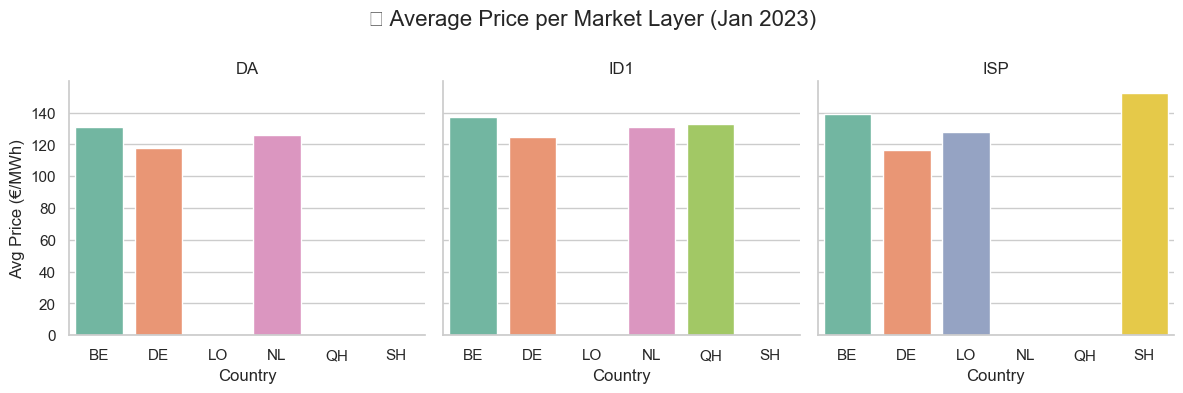

In [ ]:
# EXCLUDED UNTIL NOW
sns.set(style="whitegrid")
g = sns.catplot(
    data=avg_price,
    kind="bar",
    x="market_country",
    y="price",
    col="layer",
    palette="Set2",
    height=4,
    aspect=1
)
g.set_axis_labels("Country", "Avg Price (€/MWh)")
g.set_titles("{col_name}")
g.fig.suptitle("💰 Average Price per Market Layer (Jan 2023)", fontsize=16)
plt.subplots_adjust(top=0.8)
plt.show()
